After running the notebook to generate the FP-Growth Rules, and the server assignments based on number of servers and ensuring IP pairs are placed on the same server to the extent possible.

We now go back to our origninal dataframe, and add 2 new columns: Src_server and Dst_server, which explicately states where that IP address (or app) should have been scheduled if all other resources were available.

The number of apps per server is set int he 'Rules' notebook. In this instance we assume 20 apps/server.

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
#from apyori import apriori 

In [2]:
#testing data
#df=pd.read_csv('df_test.csv')

In [2]:
#load data

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))

df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    
    return int(total_stars)

In [4]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

#[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe

In [5]:
#load in the server assignment dataframe

#server_rules=pd.read_csv('server_rules_80_70con.csv') #original with low latency output, rules len = 329
server_rules=pd.read_csv('server_rules_80_70con_351.csv') #rules len = 351, we get them all

#these are note in a particular oder, simply sorted by IP address. However, the most important rules are associated with the lower server ids.
#a IP was assigned to the first server based on it's priorety, so server 0 had the top important IPs.

In [6]:
server_rules.head()

,Unnamed: 0,IP,serverid
0,10001_210,10001_210,17.0
1,10003_106,10003_106,9.0
2,10003_162,10003_162,3.0
3,10003_235,10003_235,4.0
4,10003_51,10003_51,15.0


In [7]:
len(server_rules)

351

In [8]:
server_rules

,Unnamed: 0,IP,serverid
0,10001_210,10001_210,17.0
1,10003_106,10003_106,9.0
2,10003_162,10003_162,3.0
3,10003_235,10003_235,4.0
4,10003_51,10003_51,15.0
5,10003_90,10003_90,17.0
6,10011_132,10011_132,2.0
7,10013_240,10013_240,16.0
8,10016_144,10016_144,17.0
9,10021_188,10021_188,8.0


In [9]:
#merge in the serverid

df_servers=df.merge(server_rules.iloc[:,1:3], left_on='Src_IP', right_on='IP', how='left')
df_servers=df_servers.rename(columns={'serverid': 'Src_Server'})

In [10]:
df_servers=df_servers.merge(server_rules.iloc[:,1:3], left_on='Dst_IP', right_on='IP', how='left')
df_servers=df_servers.rename(columns={'serverid': 'Dst_Server'})
df_servers=df_servers.drop(['IP_x', 'IP_y'], axis=1)

In [11]:
#check to see if we get any pairs
df_servers[df_servers['Src_Server']==df_servers['Dst_Server']].head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,Src_Server,Dst_Server
1490,2017-08-02 00:23:54.113,0.997,192.168.100.20,59883,10011_132,25.0,2,148,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",0.4985,2.0,2.0
1497,2017-08-02 00:23:57.115,0.000,192.168.100.20,59883,10011_132,25.0,1,74,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",0.0000,2.0,2.0
1727,2017-08-02 00:28:54.340,0.998,192.168.100.20,59886,10011_132,25.0,2,148,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",0.4990,2.0,2.0
1736,2017-08-02 00:28:57.342,0.000,192.168.100.20,59886,10011_132,25.0,1,74,2017-08-02 00:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",0.0000,2.0,2.0
3035,2017-08-02 00:58:53.915,0.999,192.168.100.20,59891,10011_132,25.0,2,148,2017-08-02 01:00:00,"[10011_132, 192.168.100.20]","(10011_132, 192.168.100.20)",0.4995,2.0,2.0


Great, at least we get some pairs. The percentage of matching pairs from the dataset is:


In [13]:
len(df_servers[df_servers['Src_Server']==df_servers['Dst_Server']])/len(df_servers)

0.01940607809047456

In [14]:
df_servers.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,Src_Server,Dst_Server
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0015,9.0,NaN
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0000,NaN,9.0
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0020,0.0,NaN
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.0000,NaN,0.0
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0000,NaN,0.0


This is not a big percentage, but makes sense because we only made rules for some of the IP pairs that were most critical.
Now, let's go through and change all the durations where we get a matching server pair to be time =0, this assumes they are on the same machine and latency is 0.

In [15]:
df_servers['duration_pred']=df_servers['Duration']

df_servers.loc[df_servers['Src_Server']==df_servers['Dst_Server'], 'duration_pred']=0

In [16]:
df_servers['Duration'].sum() #originial total latency

2014119.5810000007

In [17]:
model80_latency=df_servers['duration_pred'].sum()
model80_latency#new updated latency with the co-located apps

1884878.5070000016

In [18]:
model80_avg_latency=df_servers['duration_pred'].mean()
model80_avg_latency

0.23025657818873027

In [19]:
latency={'total_time':[ model80_latency], 'avg_time':[ model80_avg_latency], 'type':['model80']}
latency=pd.DataFrame(latency)
latency.to_csv('latency_time_80.csv')

## How much did our model improve the latency? We made a what % impact?

In [20]:
#percent change 

orig_time=df_servers['Duration'].sum()
pred_time=df_servers['duration_pred'].sum()

(orig_time-pred_time )/orig_time

0.06416752769755187

How does this compare to randomly assigning servers?

In [21]:
#need to assign random servers to the IP addressed, however b/c we did not assign a server to all the IP addresses in our model run, we will only assign servers to the same proportion of the data.

#how many servers did we assign in the Src_server column?
num_src_assign=df_servers['Src_Server'].count()
num_dst_assign=df_servers['Dst_Server'].count()

In [22]:
xx_src=np.random.choice(len(df), num_src_assign) #which rows are randomly assigned src servers
xx_dst=np.random.choice(len(df), num_dst_assign) #which rows are randomly assigned dst servers
num_servers=server_rules['serverid'].nunique()
df_servers['rnd_src_server']=None
df_servers['rnd_dst_server']=None

In [23]:
rnd_src_servers=[]
for x in range(len(xx_src)):
  rnd_src_servers.append(random.randint(0,num_servers))

In [24]:
rnd_dst_servers=[]
for x in range(len(xx_dst)):
  rnd_dst_servers.append(random.randint(0,num_servers)) #create random numbers for dst serve

In [25]:
df_servers['rnd_src_server'][xx_src]=rnd_src_servers
df_servers['rnd_dst_server'][xx_dst]=rnd_dst_servers

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
len(df_servers[df_servers.rnd_src_server==df_servers.rnd_dst_server])/len(df_servers) #we only get 0.9% matching pairs

0.008727225729025878

In [27]:
df_servers['duration_rnd']=df_servers['Duration']
df_servers['duration_rnd'][df_servers['rnd_src_server']==df_servers['rnd_dst_server']]=0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### How does this completely random assignment compare to our model?

In [28]:
df_servers['duration_pred'].sum() #new updated latency with the co-located apps

1884878.5070000016

In [29]:
(df_servers['Duration'].sum()-df_servers['duration_rnd'].sum())/ df_servers['Duration'].sum() #new updated latency with the random assignment

0.008480732803125068

The random model only improves things by almost 1%, while our model is around a 6% improvement.

Now, set the matching pairs duration = 0, and sum up the time again, just like before.

Our model performs how much better than random? A % improvement:

In [30]:
(df_servers['duration_rnd'].sum()-df_servers['duration_pred'].sum() )/df_servers['duration_rnd'].sum()

0.056163099131556954

We saved how many seconds?

In [31]:
df_servers['duration_rnd'].sum() - df_servers['duration_pred'].sum()

112159.86399999587

In [32]:
df_servers.to_csv('df_servers80.csv')

Let's make an hour timestep and see how total latency varies over time

In [33]:
hour_totals=df_servers.groupby(['date_hr'],as_index=False)[['Duration', 'duration_pred']].sum()

#hour_group2=df.groupby(['date_hr', 'pairs2'], as_index=False)['Date'].count()

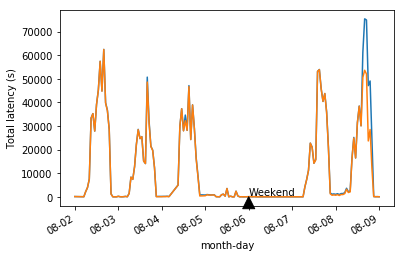

In [34]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(hour_totals['date_hr'], hour_totals['Duration'])
ax.plot(hour_totals['date_hr'], hour_totals['duration_pred'])

myFmt = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('month-day')
plt.show()

How many seconds are we saving each hour?

In [35]:
hour_totals['time_saved']=hour_totals['Duration']-hour_totals['duration_pred']

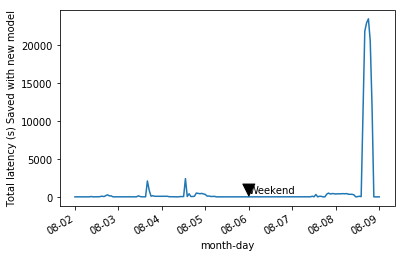

In [36]:
fig, ax = plt.subplots()
ax.plot(hour_totals['date_hr'], hour_totals['time_saved'])

myFmt = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s) Saved with new model')
plt.xlabel('month-day')
plt.show()

Hmmmm what's happening in the last day?

### What if we only implement a sub-set of the rules?
These results are for all of the rules generated by the FP-Growth algorithm being implemented. This is ~300 rules. If we do not want to implement them all, because of cost and resources, we could implement them in batches. The servers were assigned based on highest priorety rules being put in a server first. So server "1" has the IP addresses that are most valuable to be co-located, the IPs assigned to higher number servers (e.g., 20) are less important.

Let's see if we implement each batch of rules, how close we get to our total benefit.
Here % = time saved with this batch of rules / total time saved with all rules implemented

In [54]:
server_rules1=server_rules[server_rules['serverid']==1] #only implementing the rules that fit on server 1, or the top 20 IPs

In [38]:
df_servers_list=[]

batch=pd.DataFrame()
serverid=0
#memory error, lets only do a subset, if i=5 we use servers 0-5
percent_rules=[0.05, 0.25, 0.5, 0.75, 1]

server_batches=[server_rules.serverid.nunique()*x for x in percent_rules]
server_batches=[round(x) for x in server_batches]
server_batches

for i in server_batches:
    batch=df.merge(server_rules[server_rules['serverid']<=i].iloc[:,1:3], left_on='Src_IP', right_on='IP', how='left')
    batch=batch.rename(columns={'serverid': 'Src_Server'})
    batch=batch.merge(server_rules[server_rules['serverid']<=i].iloc[:,1:3], left_on='Dst_IP', right_on='IP', how='left')
    batch=batch.rename(columns={'serverid': 'Dst_Server'})
    df_servers_list.append(batch)



In [39]:
latency_avg=[]
latency_totals=[]
for i in range(len(df_servers_list)):
    df_server=df_servers_list[i]
    df_server['duration_pred']=df_server['Duration']
    df_server['duration_pred'][df_server['Src_Server']==df_servers['Dst_Server']]=0
    total_time=df_server['duration_pred'].sum()
    avg_time=df_server['duration_pred'].mean()
    latency_totals.append(total_time)
    latency_avg.append(avg_time)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
apps_server=20
num_rules=[x*apps_server for x in server_batches]
latency_matrix={'latency_total':latency_totals, 'latency_avg':latency_avg, 'percent_rules':percent_rules, 'num_rules':num_rules}
latency_matrix=pd.DataFrame.from_dict(latency_matrix)
latency_matrix['model']='per80_70con'
latency_matrix

,latency_total,latency_avg,percent_rules,num_rules,model
0,1886554.666,0.230461,0.05,20,per80_70con
1,1885068.874,0.230280,0.25,80,per80_70con
2,1884878.507,0.230257,0.50,180,per80_70con
3,1884878.507,0.230257,0.75,280,per80_70con
4,1884878.507,0.230257,1.00,360,per80_70con


In [59]:
latency_matrix.to_csv('latency_matrix_80_70con.csv')